In [1]:
import os
import xarray as xr
import numpy as np
import healpy as hp
from easygems import healpix as egh
from datetime import datetime


In [2]:
# Define zoom
zoom = 7

# Define required variables
variables = ['pr', 'uas', 'vas', 'ps', 'tas']

# Define ICON & UM Models paths
GE_path = "/g/data/qx55/germany_node/d3hp003.zarr"
GE_file = f"P1D_mean_z{zoom}_atm.zarr"

UK_path = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/"
UK_file = f"data.healpix.PT1H.z{zoom}.zarr"

# Load files
ge = xr.open_zarr(os.path.join(GE_path, GE_file))
uk = xr.open_zarr(os.path.join(UK_path, UK_file))

# Optional: more robust version
ge_vars = [v for v in variables if v in ge.variables]
uk_vars = [v for v in variables if v in uk.variables]

ge = ge[ge_vars]
uk = uk[uk_vars]

# Load ERA5 dummy file to get its grid
era5 = xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/2t/2020/2t_era5_oper_sfc_20200601-20200630.nc')

# Crop ICON & UM Models to required time range
start_time = "2020-03-01"
end_time = "2021-02-28"
uk = uk.sel(time=slice(start_time, end_time))
ge = ge.sel(time=slice(start_time, end_time))


In [3]:
uk

<xarray.Dataset> Size: 34GB
Dimensions:  (time: 8760, cell: 196608)
Coordinates:
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
    crs      float64 8B ...
  * time     (time) datetime64[ns] 70kB 2020-03-01 ... 2021-02-28T23:00:00
Data variables:
    pr       (time, cell) float32 7GB dask.array<chunksize=(40, 16384), meta=np.ndarray>
    uas      (time, cell) float32 7GB dask.array<chunksize=(40, 16384), meta=np.ndarray>
    vas      (time, cell) float32 7GB dask.array<chunksize=(40, 16384), meta=np.ndarray>
    ps       (time, cell) float32 7GB dask.array<chunksize=(40, 16384), meta=np.ndarray>
    tas      (time, cell) float32 7GB dask.array<chunksize=(40, 16384), meta=np.ndarray>
Attributes:
    Met Office DYAMOND3 simulations:  A group of experiments have been conduc...
    bounds:                           {'lower_left_lat': -90, 'lower_left_lon...
    latitiude_convention:             [-90, 90]
    longitude_convention:             [0, 360]
    regional:                         False
    simulation:                       glm.n2560_RAL3p3
    simulation_description:           The MetUM uses a regular lat-lon grid, ...

In [4]:
ge

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 365, cell: 196608)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2020-03-01 2020-03-02 ... 2021-02-28
Dimensions without coordinates: cell
Data variables:
    pr       (time, cell) float32 287MB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    uas      (time, cell) float32 287MB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    vas      (time, cell) float32 287MB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    ps       (time, cell) float32 287MB dask.array<chunksize=(1, 196608), meta=np.ndarray>
    tas      (time, cell) float32 287MB dask.array<chunksize=(1, 196608), meta=np.ndarray>
Attributes:
    hiopy::parent:  P1D_mean_z8_atm

In [5]:
# Print units for each variable in the dataset
ds = ge
for var in ds.data_vars:
    if 'units' in ds[var].attrs:
        print(f"Variable: {var}, Units: {ds[var].attrs['units']}")
    else:
        print(f"Variable: {var} does not have units attribute.")


Variable: pr, Units: kg m-2 s-1
Variable: uas, Units: m s-1
Variable: vas, Units: m s-1
Variable: ps, Units: Pa
Variable: tas, Units: K


In [6]:
# Define function to compute time averages
def seasonal_means(ds):
    ds['month'] = ds['time'].dt.month
    return {
        'full': ds.mean(dim='time'),
        'DJF': ds.sel(time=ds['month'].isin([12, 1, 2])).mean(dim='time'),
        'MAM': ds.sel(time=ds['month'].isin([3, 4, 5])).mean(dim='time'),
        'JJA': ds.sel(time=ds['month'].isin([6, 7, 8])).mean(dim='time'),
        'SON': ds.sel(time=ds['month'].isin([9, 10, 11])).mean(dim='time'),
    }

seasons_uk = seasonal_means(uk)
seasons_ge = seasonal_means(ge)


In [7]:
# Define regrid function
def regrid_to_era5(ds, era5):
    # Get lat/lon from ERA5
    lon = era5['longitude'].values
    lat = era5['latitude'].values

    # Use any data variable with 'cell' dim to infer nside
    for var in ds.data_vars:
        if 'cell' in ds[var].dims:
            nside = hp.get_nside(ds[var].values)
            break
    else:
        raise ValueError("No variable with 'cell' dimension found to infer nside.")

    # Build nearest neighbor index array
    def get_nn_lon_lat_index(nside, lons, lats):
        lons2, lats2 = np.meshgrid(lons, lats)
        return xr.DataArray(
            hp.ang2pix(nside, lons2, lats2, nest=True, lonlat=True),
            coords=[("lat", lats), ("lon", lons)],
        )

    cells = get_nn_lon_lat_index(nside, lon, lat)

    # Regrid using nearest HEALPix cell index
    ds_regridded = ds.isel(cell=cells)

    # Convert longitudes from [-180, 180] to [0, 360]
    if 'lon' in ds_regridded.coords:
        ds_regridded = ds_regridded.assign_coords(
            lon=((ds_regridded.lon + 360) % 360)
        ).sortby('lon')

    return ds_regridded

uk_regridded = {season: regrid_to_era5(ds, era5) for season, ds in seasons_uk.items()}
ge_regridded = {season: regrid_to_era5(ds, era5) for season, ds in seasons_ge.items()}


In [8]:
def copy_attributes(original_ds, new_ds):
    """Copy only 'unit' and 'long_name' attributes from original_ds to new_ds"""
    for var in original_ds.data_vars:
        if var in new_ds:
            for attr in ['units', 'unit', 'long_name']:
                if attr in original_ds[var].attrs:
                    new_ds[var].attrs[attr] = original_ds[var].attrs[attr]
    return new_ds


In [9]:
# Output path
record_path = '/scratch/nf33/hk25-ConvZones'

# Save function
def save_seasonal_regridded(model_name, original_ds, regridded_dict):
    for season, ds in regridded_dict.items():
        # Copy variable attributes
        ds_with_attrs = copy_attributes(original_ds, ds)

        # Define filename
        season_tag = 'tot' if season == 'full' else season.lower()
        filename = f"{model_name}_{season_tag}_avg_202003_202102.nc"
        filepath = os.path.join(record_path, filename)

        # Compression settings
        encoding = {var: {'zlib': True, 'complevel': 2} for var in ds_with_attrs.data_vars}

        # Write NetCDF
        ds_with_attrs.to_netcdf(filepath, encoding=encoding)
        print(f"Saved: {filepath}")

# Save UK (UM) regridded data
save_seasonal_regridded("UM", uk, uk_regridded)

# Save GE (ICON) regridded data
save_seasonal_regridded("ICON", ge, ge_regridded)

Saved: /scratch/nf33/hk25-ConvZones/UM_tot_avg_202003_202102.nc
Saved: /scratch/nf33/hk25-ConvZones/UM_djf_avg_202003_202102.nc
Saved: /scratch/nf33/hk25-ConvZones/UM_mam_avg_202003_202102.nc
Saved: /scratch/nf33/hk25-ConvZones/UM_jja_avg_202003_202102.nc
Saved: /scratch/nf33/hk25-ConvZones/UM_son_avg_202003_202102.nc
Saved: /scratch/nf33/hk25-ConvZones/ICON_tot_avg_202003_202102.nc
Saved: /scratch/nf33/hk25-ConvZones/ICON_djf_avg_202003_202102.nc
Saved: /scratch/nf33/hk25-ConvZones/ICON_mam_avg_202003_202102.nc
Saved: /scratch/nf33/hk25-ConvZones/ICON_jja_avg_202003_202102.nc
Saved: /scratch/nf33/hk25-ConvZones/ICON_son_avg_202003_202102.nc


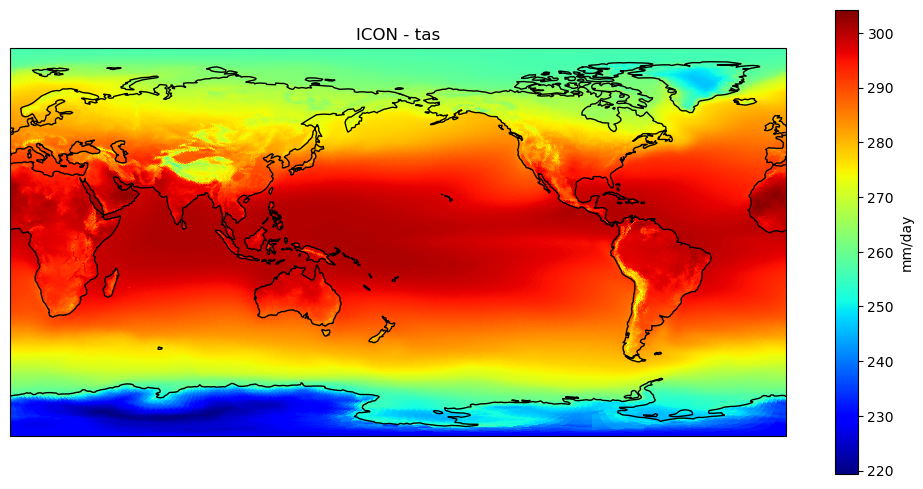

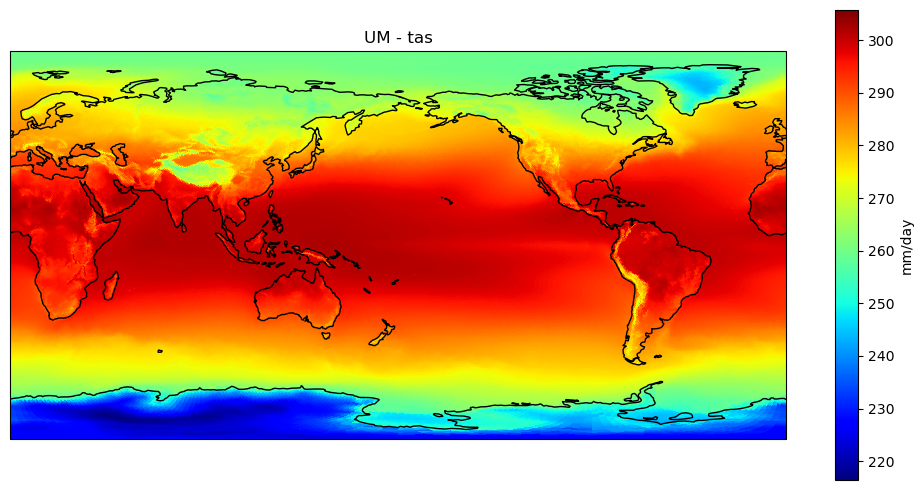

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# File paths
icon_path = "/scratch/nf33/hk25-ConvZones/ICON_tot_avg_202003_202102.nc"
um_path   = "/scratch/nf33/hk25-ConvZones/UM_tot_avg_202003_202102.nc"

# Open datasets
ds_icon = xr.open_dataset(icon_path)
ds_um = xr.open_dataset(um_path)

# Define variable to check
var = 'tas'

# Plot function
def plot_precip(ds, model_name):
    if 'pr' not in ds:
        print(f"'pr' not found in {model_name} dataset.")
        return
    ds = ds[var]  # Convert from kg m-2 s-1 to mm/day if needed

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, figsize=(10, 5))
    ds.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='jet', cbar_kwargs={'label': 'mm/day'})
    ax.coastlines()
    ax.set_title(f'{model_name} - {var}')
    plt.tight_layout()
    plt.show()

# Plot both
plot_precip(ds_icon, "ICON")
plot_precip(ds_um, "UM")


In [11]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [12]:
ds_icon

<xarray.Dataset> Size: 21MB
Dimensions:  (lat: 721, lon: 1440)
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    pr       (lat, lon) float32 4MB ...
    uas      (lat, lon) float32 4MB ...
    vas      (lat, lon) float32 4MB ...
    ps       (lat, lon) float32 4MB ...
    tas      (lat, lon) float32 4MB ...
    month    float64 8B ...

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Extract and scale to mm/day
pr_uk = uk_regridded['full']['tas'] # * 86400
pr_ge = ge_regridded['full']['tas'] # * 86400

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot UK model
pr_uk.plot.pcolormesh(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    cmap='jet'
)
axes[0].set_title("UK Model - Full Average")
axes[0].coastlines()

# Plot GE model
pr_ge.plot.pcolormesh(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    cmap='jet'
)
axes[1].set_title("GE Model - Full Average")
axes[1].coastlines()

plt.show()
